In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import json
import numpy as np
import pandas as pd
import string
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb
import sys
import seaborn as sns
from sklearn import preprocessing
#import lightgbm as lgb 

In [5]:
millionsub = pd.read_csv('..\\data\\extracted\\million_song_subset.csv')
msdset = pd.read_csv('..\\data\\extracted\\msdset.csv')

hot100 = pd.read_csv('..\\data\\extracted\\hot-100.csv')
albumcat = pd.read_csv('..\\data\\extracted\\catalog-albums.csv')
songsale = pd.read_csv('..\\data\\extracted\\digital-song-sales.csv')
popsongs = pd.read_csv('..\\data\\extracted\\pop-songs.csv')
radiosongs = pd.read_csv('..\\data\\extracted\\radio-songs.csv')
streamingsongs = pd.read_csv('..\\data\\extracted\\streaming-songs.csv')
topabsale = pd.read_csv('..\\data\\extracted\\top-album-sales.csv')
youtubesongs = pd.read_csv('..\\data\\extracted\\youtube.csv')

In [6]:
hot100

,title,chart_date,artist_name,peak_rank,last_rank,on_chart_weeks,current_rank,is_new
0,Girls Like You,2018-11-10,Maroon 5 Featuring Cardi B,1,1,23,1,False
1,Sicko Mode,2018-11-10,Travis Scott,2,2,13,2,False
2,Happier,2018-11-10,Marshmello & Bastille,3,4,11,3,False
3,Lucid Dreams,2018-11-10,Juice WRLD,2,3,25,4,False
4,Better Now,2018-11-10,Post Malone,3,5,27,5,False
5,ZEZE,2018-11-10,Kodak Black Featuring Travis Scott & Offset,2,6,3,6,False
6,Youngblood,2018-11-10,5 Seconds Of Summer,7,7,22,7,False
7,Drip Too Hard,2018-11-10,Lil Baby & Gunna,4,8,7,8,False
8,Without Me,2018-11-10,Halsey,9,12,4,9,False
9,Mo Bamba,2018-11-10,Sheck Wes,10,16,10,10,False


In [7]:
sniff = hot100[['title','chart_date','artist_name']]

In [8]:
last_time = sniff['chart_date'].groupby([sniff['title'], sniff['artist_name']]).max()
first_time = sniff['chart_date'].groupby([sniff['title'], sniff['artist_name']]).min()

In [9]:
lifespan=pd.DataFrame({'first_time':first_time,'last_time':last_time})
lifespan['first_time']=pd.to_datetime(lifespan['first_time'],format='%Y-%m-%d')
lifespan['last_time']=pd.to_datetime(lifespan['last_time'],format='%Y-%m-%d')

In [10]:
lifespan['dayspan']=(lifespan['last_time']-lifespan['first_time']).dt.days

In [11]:
lifespan['yearspan']=lifespan['dayspan']/365.25

In [12]:
lifespan.sort_values(by=['dayspan','title'], ascending=False).head(20)

,,first_time,last_time,dayspan,yearspan
title,artist_name,,,,
Jingle Bell Rock,Bobby Helms,1958-12-22,2018-01-03,21562,59.033539
The Christmas Song (Merry Christmas To You),Nat King Cole,1960-12-12,2018-01-06,20844,57.067762
Rockin' Around The Christmas Tree,Brenda Lee,1960-12-12,2018-01-06,20844,57.067762
Space Oddity,David Bowie,1973-01-27,2016-01-30,15708,43.006160
Thriller,Michael Jackson,1984-02-11,2018-11-10,12691,34.746064
Under Pressure,Queen & David Bowie,1981-11-07,2016-01-30,12502,34.228611
1999,Prince,1982-10-30,2016-05-14,12250,33.538672
Little Red Corvette,Prince,1983-02-26,2016-05-14,12131,33.212868
Careless Whisper,Wham! Featuring George Michael,1984-12-22,2017-01-14,11711,32.062971


In [107]:
jinglebell = sniff[sniff.title=='Jingle Bell Rock']['chart_date']
jinglebell

4549      2018-01-03
9728      2017-01-07
9845      2016-12-31
9934      2016-12-24
14946     2016-01-09
291655    1962-12-29
291758    1962-12-22
291791    1962-12-22
291886    1962-12-15
291896    1962-12-15
291998    1962-12-08
296622    1962-01-13
296720    1962-01-06
296740    1962-01-06
296826    1961-12-25
296848    1961-12-25
296944    1961-12-18
296957    1961-12-18
297067    1961-12-11
297070    1961-12-11
302035    1960-12-26
302145    1960-12-19
302268    1960-12-12
312369    1959-01-12
312444    1959-01-05
312534    1958-12-29
312656    1958-12-22
Name: chart_date, dtype: object

In [108]:
jinglebell = sniff[sniff.title=='The Christmas Song (Merry Christmas To You)']['chart_date']
jinglebell

4441      2018-01-06
4536      2018-01-03
4637      2017-12-30
4741      2017-12-23
9746      2017-01-07
14937     2016-01-09
25444     2014-01-04
291664    1962-12-29
291766    1962-12-22
291874    1962-12-15
302179    1960-12-19
302299    1960-12-12
Name: chart_date, dtype: object

In [109]:
jinglebell = sniff[sniff.title=='Thriller']['chart_date']
jinglebell

30        2018-11-10
15644     2015-11-21
20934     2014-11-15
26141     2013-11-16
180198    1984-05-12
180295    1984-05-05
180376    1984-04-28
180468    1984-04-21
180546    1984-04-14
180622    1984-04-07
180714    1984-03-31
180810    1984-03-24
180905    1984-03-17
181003    1984-03-10
181103    1984-03-03
181204    1984-02-25
181306    1984-02-18
181419    1984-02-11
Name: chart_date, dtype: object

In [110]:
jinglebell = sniff[sniff.title=='Billie Jean']['chart_date']
jinglebell

23213     2014-06-07
54546     2008-06-07
184697    1983-07-02
184772    1983-06-25
184869    1983-06-18
184964    1983-06-11
185057    1983-06-04
185141    1983-05-28
185228    1983-05-21
185323    1983-05-14
185413    1983-05-07
185506    1983-04-30
185604    1983-04-23
185700    1983-04-16
185800    1983-04-09
185900    1983-04-02
186000    1983-03-26
186100    1983-03-19
186200    1983-03-12
186300    1983-03-05
186403    1983-02-26
186505    1983-02-19
186622    1983-02-12
186726    1983-02-05
186836    1983-01-29
186946    1983-01-22
Name: chart_date, dtype: object

In [111]:
jinglebell = sniff[sniff.title=='Do You Love Me']['chart_date']
jinglebell

157486    1988-09-17
157570    1988-09-10
157659    1988-09-03
157740    1988-08-27
157821    1988-08-20
157914    1988-08-13
158010    1988-08-06
158113    1988-07-30
158216    1988-07-23
158323    1988-07-16
158427    1988-07-09
158532    1988-07-02
158644    1988-06-25
158757    1988-06-18
158875    1988-06-11
158990    1988-06-04
180797    1984-03-31
180887    1984-03-24
180981    1984-03-17
181084    1984-03-10
181188    1984-03-03
283739    1964-07-04
283833    1964-06-27
283923    1964-06-20
284013    1964-06-13
284110    1964-06-06
284211    1964-05-30
284317    1964-05-23
284421    1964-05-16
284531    1964-05-09
284652    1964-05-02
291941    1962-12-08
292025    1962-12-01
292123    1962-11-24
292215    1962-11-17
292308    1962-11-10
292402    1962-11-03
292502    1962-10-27
292602    1962-10-20
292706    1962-10-13
292814    1962-10-06
292918    1962-09-29
293027    1962-09-22
293141    1962-09-15
293254    1962-09-08
293368    1962-09-01
293481    1962-08-25
293593    196

(array([2.7577e+04, 1.4400e+02, 2.7000e+01, 1.4000e+01, 1.3000e+01,
        8.0000e+00, 5.0000e+00, 7.0000e+00, 0.0000e+00, 4.0000e+00,
        1.0000e+00, 3.0000e+00, 2.0000e+00, 3.0000e+00, 2.0000e+00,
        1.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 5.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 3.0000e+00, 4.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([ 0.        ,  0.98389231,  1.96778462,  2.95167693,  3.93556924,
         4.91946156,  5.90335387,  6.88724618,  7.87113849,  8.8550308 ,
         9.83892311, 10.82281542, 11

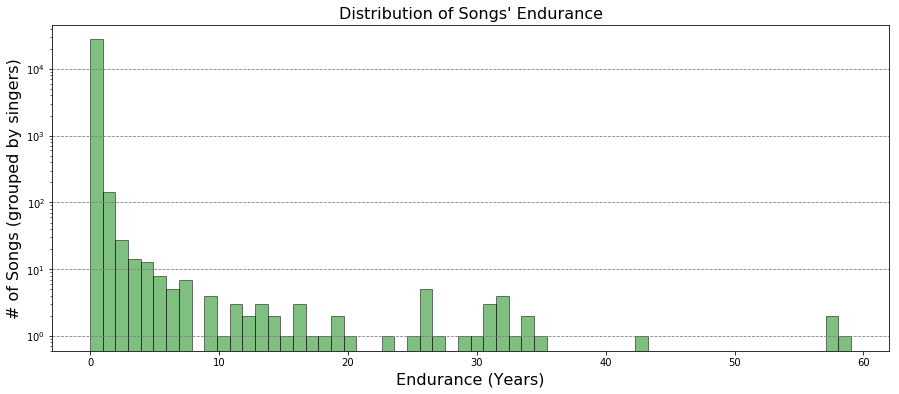

In [13]:
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Endurance (Years)', size=16)
ax1.set_ylabel('# of Songs (grouped by singers)', size=16)
ax1.set_title('Distribution of Songs\' Endurance', size=16)
plt.grid(axis = 'y', linestyle = '--', color='gray')
ax1.patch.set_facecolor("white")
ax1.spines['left'].set_color('black')
ax1.spines['bottom'].set_color('black')
plt.hist(lifespan['yearspan'], bins=60,facecolor="green", edgecolor="black", log=True, alpha=0.5)

In [14]:
song_last_time = sniff['chart_date'].groupby([sniff['title']]).max()
song_first_time = sniff['chart_date'].groupby([sniff['title']]).min()

In [15]:
song_lifespan=pd.DataFrame({'first_time':song_first_time,'last_time':song_last_time})
song_lifespan['first_time']=pd.to_datetime(song_lifespan['first_time'],format='%Y-%m-%d')
song_lifespan['last_time']=pd.to_datetime(song_lifespan['last_time'],format='%Y-%m-%d')

In [16]:
song_lifespan['dayspan']=(song_lifespan['last_time']-song_lifespan['first_time']).dt.days

In [17]:
song_lifespan['yearspan']=song_lifespan['dayspan']/365.25

In [18]:
song_lifespan.sort_values(by=['dayspan','title'], ascending=False).head(20)

,first_time,last_time,dayspan,yearspan
title,,,,
Problems,1958-11-10,2018-10-13,21887,59.923340
Midnight,1958-08-11,2018-03-24,21775,59.616701
Mona Lisa,1959-06-01,2018-11-10,21712,59.444216
High Hopes,1959-06-15,2018-11-10,21698,59.405886
Try Me,1958-12-15,2018-04-21,21677,59.348392
Plain Jane,1959-01-26,2018-03-24,21607,59.156742
Talk To Me,1959-10-19,2018-11-10,21572,59.060917
Jingle Bell Rock,1958-12-22,2018-01-03,21562,59.033539
Paris,1958-10-20,2017-06-17,21425,58.658453


(array([2.0382e+04, 2.2400e+02, 1.4900e+02, 1.2000e+02, 1.1500e+02,
        8.2000e+01, 8.4000e+01, 8.4000e+01, 7.9000e+01, 8.0000e+01,
        5.5000e+01, 7.1000e+01, 8.2000e+01, 6.9000e+01, 7.0000e+01,
        6.1000e+01, 5.7000e+01, 6.2000e+01, 6.2000e+01, 6.5000e+01,
        6.1000e+01, 5.8000e+01, 3.9000e+01, 5.0000e+01, 3.8000e+01,
        4.0000e+01, 3.3000e+01, 4.9000e+01, 4.2000e+01, 4.3000e+01,
        4.1000e+01, 3.3000e+01, 3.1000e+01, 3.9000e+01, 3.0000e+01,
        2.4000e+01, 3.4000e+01, 2.4000e+01, 2.4000e+01, 2.6000e+01,
        2.1000e+01, 1.9000e+01, 2.6000e+01, 2.9000e+01, 2.1000e+01,
        2.2000e+01, 1.9000e+01, 2.6000e+01, 1.6000e+01, 2.0000e+01,
        1.3000e+01, 1.1000e+01, 1.3000e+01, 1.0000e+01, 1.1000e+01,
        1.5000e+01, 7.0000e+00, 7.0000e+00, 6.0000e+00, 8.0000e+00]),
 array([ 0.        ,  0.99872234,  1.99744467,  2.99616701,  3.99488935,
         4.99361168,  5.99233402,  6.99105635,  7.98977869,  8.98850103,
         9.98722336, 10.9859457 , 11

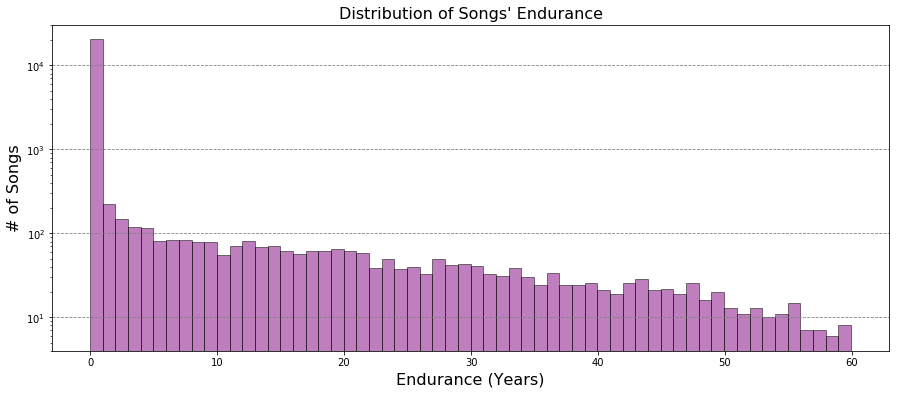

In [19]:
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Endurance (Years)', size=16)
ax1.set_ylabel('# of Songs', size=16)
ax1.set_title('Distribution of Songs\' Endurance', size=16)
plt.grid(axis = 'y', linestyle = '--', color='gray')
ax1.patch.set_facecolor("white")
ax1.spines['left'].set_color('black')
ax1.spines['bottom'].set_color('black')
plt.hist(song_lifespan['yearspan'], bins=60,facecolor="purple", edgecolor="black", log=True, alpha=0.5)

In [20]:
singer_sniff = hot100[['chart_date','artist_name']]

In [21]:
singer_last_time = singer_sniff['chart_date'].groupby([singer_sniff['artist_name']]).max()
singer_first_time = singer_sniff['chart_date'].groupby([singer_sniff['artist_name']]).min()

In [22]:
singer_lifespan=pd.DataFrame({'first_time':singer_first_time,'last_time':singer_last_time})
singer_lifespan['first_time']=pd.to_datetime(singer_lifespan['first_time'],format='%Y-%m-%d')
singer_lifespan['last_time']=pd.to_datetime(singer_lifespan['last_time'],format='%Y-%m-%d')

In [23]:
singer_lifespan['dayspan']=(singer_lifespan['last_time']-singer_lifespan['first_time']).dt.days

In [24]:
singer_lifespan['yearspan']=singer_lifespan['dayspan']/365.25

In [25]:
singer_lifespan.sort_values(by=['dayspan'], ascending=False).head(20)

,first_time,last_time,dayspan,yearspan
artist_name,,,,
Nat King Cole,1958-08-11,2018-01-06,21698,59.405886
Bobby Helms,1958-08-18,2018-01-03,21688,59.378508
Andy Williams,1958-09-01,2018-01-06,21677,59.348392
Brenda Lee,1959-12-21,2018-01-06,21201,58.045175
Burl Ives,1961-12-18,2018-01-06,20473,56.052019
Glen Campbell,1961-10-30,2014-11-01,19360,53.004791
Jose Feliciano,1968-07-27,2018-01-03,18057,49.437372
Michael Jackson,1971-10-30,2018-11-10,17178,47.030801
Elvis Presley,1958-11-03,2003-10-04,16406,44.917180


(array([6.793e+03, 5.650e+02, 3.590e+02, 2.920e+02, 2.280e+02, 1.650e+02,
        1.560e+02, 1.160e+02, 9.800e+01, 7.600e+01, 8.400e+01, 6.100e+01,
        6.100e+01, 4.400e+01, 3.600e+01, 3.600e+01, 3.300e+01, 2.800e+01,
        2.300e+01, 2.200e+01, 1.800e+01, 1.700e+01, 8.000e+00, 1.000e+01,
        8.000e+00, 4.000e+00, 8.000e+00, 8.000e+00, 3.000e+00, 4.000e+00,
        5.000e+00, 7.000e+00, 4.000e+00, 3.000e+00, 4.000e+00, 0.000e+00,
        1.000e+00, 4.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 3.000e+00]),
 array([ 0.        ,  0.99009811,  1.98019621,  2.97029432,  3.96039243,
         4.95049053,  5.94058864,  6.93068674,  7.92078485,  8.91088296,
         9.90098106, 10.89107917, 11.88117728, 12.87127538, 13.86137349,
        14.85147159, 15.8415697 , 16.83

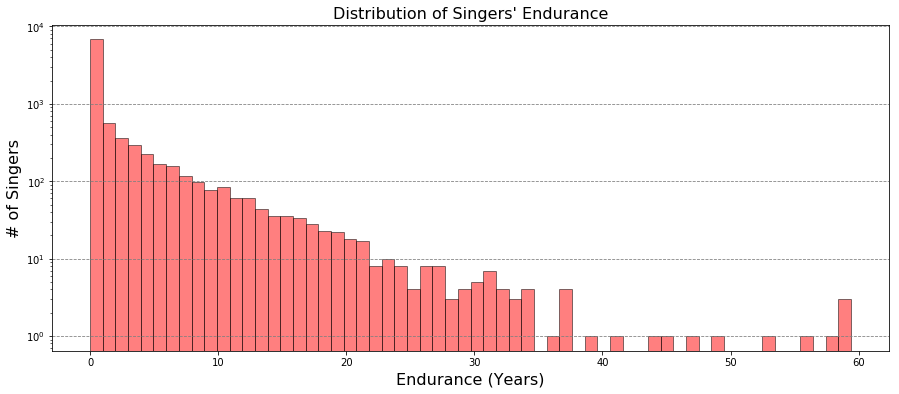

In [26]:
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Endurance (Years)', size=16)
ax1.set_ylabel('# of Singers', size=16)
ax1.set_title('Distribution of Singers\' Endurance', size=16)
plt.grid(axis = 'y', linestyle = '--', color='gray')
ax1.patch.set_facecolor("white")
ax1.spines['left'].set_color('black')
ax1.spines['bottom'].set_color('black')
plt.hist(singer_lifespan['yearspan'], bins=60,facecolor="red", edgecolor="black", log=True, alpha=0.5)

In [27]:
lifespan

,,first_time,last_time,dayspan,yearspan
title,artist_name,,,,
"""B"" Girls",Young And Restless,1990-05-05,1990-08-11,98,0.268309
"""Cherry Cherry"" from Hot August Night",Neil Diamond,1973-03-17,1973-05-19,63,0.172485
"""Having A Party"" Medley",The Ovations (Featuring Louis Williams),1973-10-13,1973-12-08,56,0.153320
"""Joy"" Pt. I",Isaac Hayes,1973-12-22,1974-02-16,56,0.153320
"""Roots"" Medley",Quincy Jones,1977-03-05,1977-04-16,42,0.114990
"""Yep!""",Duane Eddy His Twangy Guitar And The Rebels,1959-03-30,1959-05-25,56,0.153320
#1,Nelly,2001-10-20,2002-03-02,133,0.364134
#1 Dee Jay,Goody Goody,1978-11-18,1978-12-16,28,0.076660
#9 Dream,John Lennon,1974-12-21,1975-03-08,77,0.210815


In [28]:
sniff.sort_values(axis=0,by=['title','chart_date'])

,title,chart_date,artist_name
148983,"""B"" Girls",1990-05-05,Young And Restless
148877,"""B"" Girls",1990-05-12,Young And Restless
148767,"""B"" Girls",1990-05-19,Young And Restless
148659,"""B"" Girls",1990-05-26,Young And Restless
148557,"""B"" Girls",1990-06-02,Young And Restless
148454,"""B"" Girls",1990-06-09,Young And Restless
148353,"""B"" Girls",1990-06-16,Young And Restless
148256,"""B"" Girls",1990-06-23,Young And Restless
148166,"""B"" Girls",1990-06-30,Young And Restless
148074,"""B"" Girls",1990-07-07,Young And Restless


In [29]:
songsale

,title,chart_date,artist_name,peak_rank,last_rank,on_chart_weeks,current_rank,is_new
0,Shallow,2018-11-10,Lady Gaga & Bradley Cooper,1,1,6,1,False
1,Without Me,2018-11-10,Halsey,2,3,5,2,False
2,A Million Dreams,2018-11-10,P!nk,3,41,2,3,False
3,Happier,2018-11-10,Marshmello & Bastille,2,4,10,4,False
4,Money,2018-11-10,Cardi B,5,10,2,5,False
5,Always Remember Us This Way,2018-11-10,Lady Gaga,2,2,4,6,False
6,High Hopes,2018-11-10,Panic! At The Disco,4,7,12,7,False
7,I'll Never Love Again,2018-11-10,Lady Gaga,2,5,4,8,False
8,Natural,2018-11-10,Imagine Dragons,2,8,16,9,False
9,Monster Mash,2018-11-10,"Bobby ""Boris"" Pickett And The Crypt-Kickers",10,0,12,10,False


In [30]:
msdset

,file_id,song_id,post_year,artist_id,artist_hotness,artist_name,danceability,duration,end_of_fade_in,energy,loudness,song_hotness,start_of_fade_out,tempo,title
0,A/E/E/TRAEEGO12903CF7D27,SOGXWRE12AC468BE24,1966,ARTXS851187FB411C7,0.338575,Chris Farlowe,0.0,177.57995,0.346,0.0,-11.027,NaN,175.078,146.913,Paint It Black
1,A/E/E/TRAEEIJ128F92DFEDB,SONEGRP12A58A7F9DB,1997,ARXGQ2X1187FB4B346,0.389039,Charles Brown,0.0,167.81016,0.136,0.0,-17.772,0.262309,162.946,142.058,More Than You Know
2,A/E/E/TRAEEMK12903CF5AD5,SOEMNOG12AC960A5E3,1995,ARY6PB61187FB45550,0.373021,Dub War,0.0,236.51220,0.984,0.0,-7.632,0.000000,231.178,105.845,Strike It (Vpro Radio Session)
3,A/E/E/TRAEEVW128F4244269,SOJJUPJ12A6D4FC655,0,AR0CJQS1187FB42BEB,0.273445,Big Maceo Merriweather,0.0,175.85587,0.566,0.0,-15.873,0.482867,169.755,169.170,Chicago Breakdown
4,A/E/E/TRAEEDH128F932BF7D,SOBGCUO12A6D4FB2B0,2006,AR5CKT41187B9B9AB0,0.436170,Presuntos Implicados,0.0,249.80853,0.000,0.0,-8.518,NaN,240.013,116.924,Mil Mariposas
5,A/E/E/TRAEEPV12903D0D41E,SOQIZJK12AC468A970,0,ARQLRU41187B9BA210,0.252176,Steal Vybe,0.0,390.68689,2.206,0.0,-11.001,NaN,371.020,123.993,In Praise Of Eros
6,A/E/E/TRAEEUO128F92EF8AD,SOQDIXT12AB0183AC1,2009,ARF51HV1187B99E60D,0.372009,DJ Sequenza,0.0,326.05995,0.000,0.0,-8.435,NaN,322.072,85.320,Tricky Tricky 2009
7,A/E/E/TRAEEKM12903CA3944,SONLJFQ12AB0185C45,0,ARBE6DA1187B9B38B4,0.296682,Clarence Williams' Blue Five,0.0,156.21179,0.321,0.0,-13.345,NaN,152.677,93.862,Pile of Logs and Stones
8,A/E/E/TRAEEWM12903CBB182,SOIBMZT12AB0188166,0,ARSCPQV11F50C4965C,0.000000,Laura Welland,0.0,316.57751,0.363,0.0,-16.514,0.000000,294.400,56.492,I'll Be Seeing You
9,A/E/E/TRAEELW128F933D255,SOMUYIL12AB0184EE2,0,AR1QXAQ1187FB47FAC,0.403784,Sticky Fingaz & Omar Epps,0.0,142.86322,0.000,0.0,-9.532,NaN,137.033,87.897,Don't Owe Me Nothin'


In [84]:
import matplotlib as mpl
mpl.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

In [92]:
sns.set(rc={'figure.figsize':(16,8)})
sns.set(rc={
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'axes.labelsize': 20,
})


In [93]:
msdset.describe()

,post_year,artist_hotness,danceability,duration,end_of_fade_in,energy,loudness,song_hotness,start_of_fade_out,tempo
count,1000000.000000,999988.000000,1000000.0,1000000.000000,1000000.000000,1000000.0,1000000.000000,581965.000000,1000000.000000,1000000.000000
mean,1030.325652,0.379813,0.0,249.500755,0.819850,0.0,-10.124039,0.356051,240.625024,123.889218
std,998.745002,0.125960,0.0,126.229636,3.304457,0.0,5.197245,0.234441,124.079924,35.055981
min,0.000000,0.000000,0.0,0.313020,0.000000,0.0,-58.178000,0.000000,0.313000,0.000000
25%,0.000000,0.336324,0.0,180.740770,0.000000,0.0,-12.672000,0.215080,173.180000,97.995000
50%,1969.000000,0.386194,0.0,228.858320,0.194000,0.0,-8.963000,0.377532,219.759000,122.086000
75%,2002.000000,0.444066,0.0,289.932610,0.432000,0.0,-6.386000,0.531985,279.713000,144.089000
max,2011.000000,1.082503,0.0,3034.905670,1163.941000,0.0,4.318000,1.000000,3030.622000,302.300000


In [94]:
hpy_msdset = msdset[msdset.post_year!=0]

In [95]:
hpy_msdset.describe()

,post_year,artist_hotness,danceability,duration,end_of_fade_in,energy,loudness,song_hotness,start_of_fade_out,tempo
count,515576.000000,515574.000000,515576.0,515576.000000,515576.000000,515576.0,515576.000000,346444.000000,515576.000000,515576.000000
mean,1998.397233,0.415794,0.0,246.869039,0.870212,0.0,-9.699495,0.430713,237.819347,124.785618
std,10.930534,0.108140,0.0,115.546554,3.501286,0.0,4.942172,0.214577,113.329394,34.872950
min,1922.000000,0.000000,0.0,0.313020,0.000000,0.0,-57.004000,0.000000,0.313000,0.000000
25%,1994.000000,0.364339,0.0,183.144040,0.000000,0.0,-12.176000,0.304170,175.334000,98.992000
50%,2002.000000,0.409634,0.0,229.955460,0.195000,0.0,-8.614000,0.459158,220.648000,122.489000
75%,2006.000000,0.468463,0.0,287.137510,0.434000,0.0,-6.128000,0.581388,276.753000,145.274000
max,2011.000000,1.082503,0.0,3024.665670,991.359000,0.0,4.150000,1.000000,3020.301000,280.955000


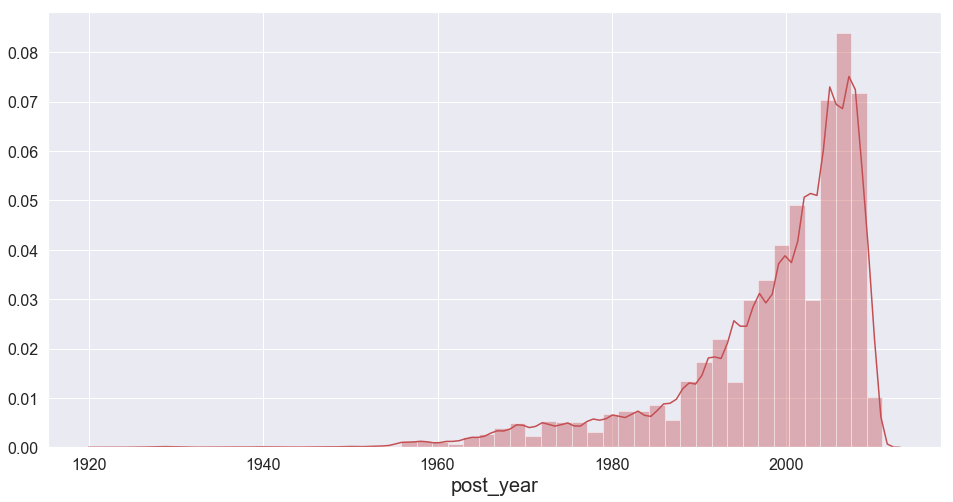

In [96]:
sns.distplot(hpy_msdset.post_year, color='r')

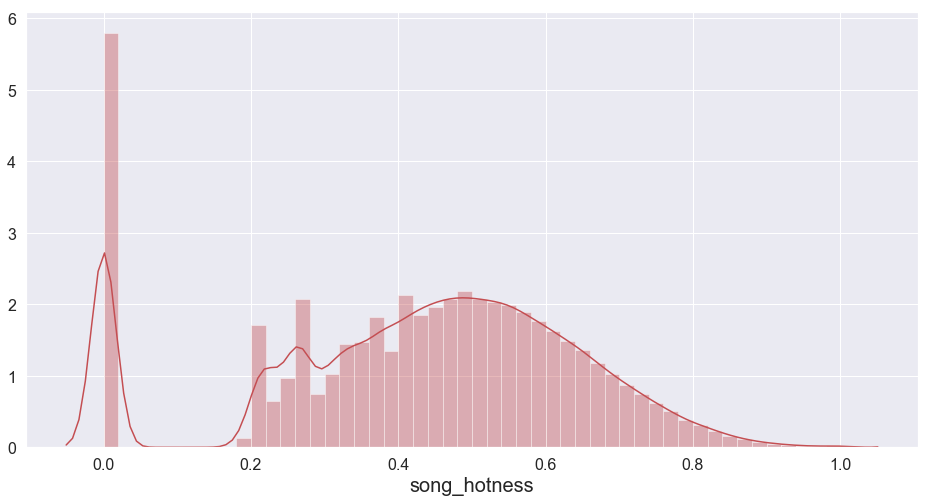

In [97]:
sns.distplot(hpy_msdset.song_hotness[~hpy_msdset.song_hotness.isnull()], color='r')

In [57]:
hot100.describe()

,peak_rank,last_rank,on_chart_weeks,current_rank
count,314600.000000,314600.000000,314600.000000,314600.000000
mean,41.219056,43.129050,8.934336,50.500010
std,29.368429,30.139843,7.486750,28.866033
min,1.000000,0.000000,0.000000,1.000000
25%,14.000000,16.000000,4.000000,26.000000
50%,39.000000,42.000000,7.000000,51.000000
75%,66.000000,69.000000,13.000000,75.000000
max,100.000000,100.000000,87.000000,100.000000


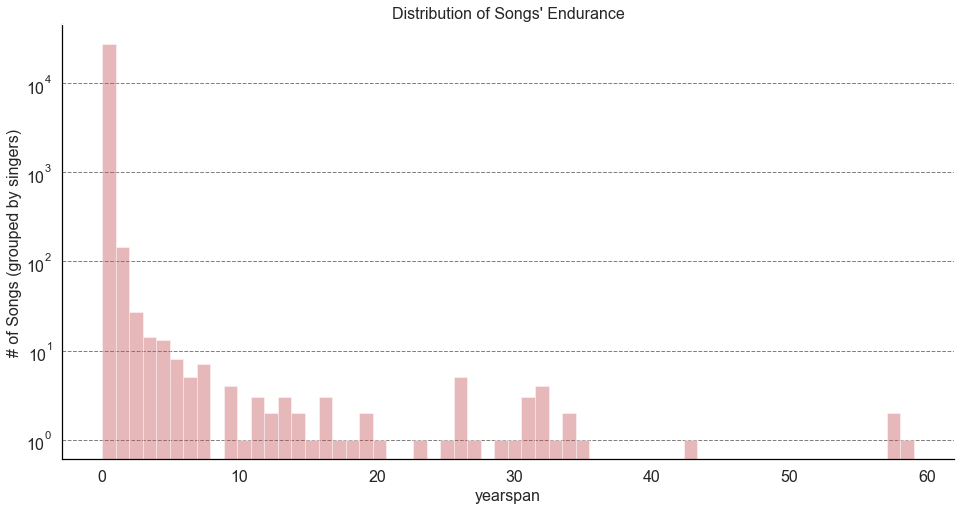

In [102]:
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Endurance (Years)', size=16)
ax1.set_ylabel('# of Songs (grouped by singers)', size=16)
ax1.set_title('Distribution of Songs\' Endurance', size=16)
plt.grid(axis = 'y', linestyle = '--', color='gray')
ax1.patch.set_facecolor("white")
ax1.spines['left'].set_color('black')
ax1.spines['bottom'].set_color('black')
ax1.set(yscale="log")
sns.distplot(lifespan['yearspan'], bins=60, color="r", ax=ax1, kde=False)

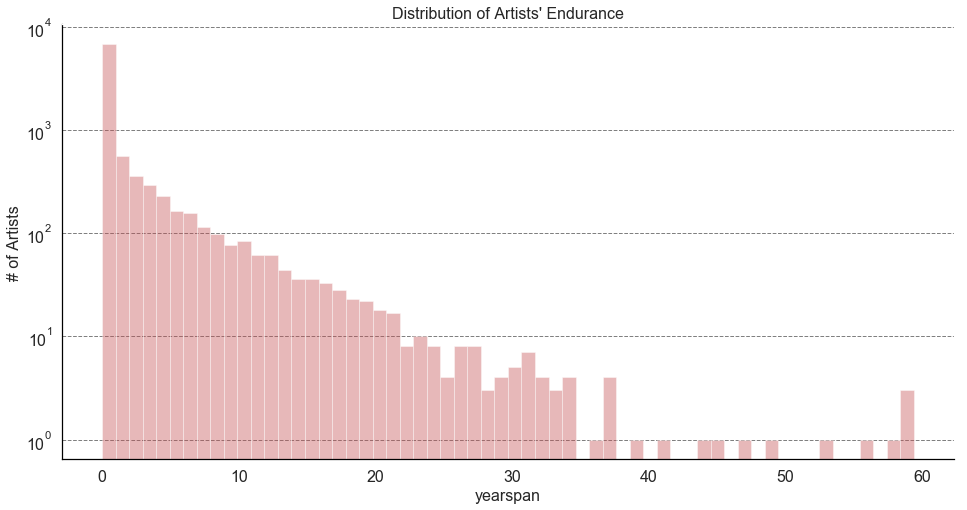

In [105]:
fig = plt.figure(figsize = (16,8))
ax2 = fig.add_subplot(111)
ax2.set_xlabel('Endurance (Years)', size=16)
ax2.set_ylabel('# of Artists', size=16)
ax2.set_title('Distribution of Artists\' Endurance', size=16)
plt.grid(axis = 'y', linestyle = '--', color='gray')
ax2.patch.set_facecolor("white")
ax2.spines['left'].set_color('black')
ax2.spines['bottom'].set_color('black')
ax2.set(yscale="log")
sns.distplot(singer_lifespan['yearspan'], bins=60, color="r", ax=ax2, kde=False)